In [1]:
import numpy as np
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import StabilizerState

# Step 1. Write functions for circuit construction

## 1.1. Setup circuit in logical state $\ket{\overline{00}}$

State $\ket{\overline{00}}$ may be found as a state stabilized by all code stabilizers and $Z_{L1}, Z_{L2}$ operators

In [2]:
Hz = np.zeros((6,12), dtype=bool)
Hx = np.zeros((6,12), dtype=bool)

Hz[0, [0, 2, 7, 9]] = True
Hz[1, [0, 1, 8, 10]] = True
Hz[2, [1, 2, 6, 11]] = True
Hz[3, [3, 5, 6, 10]] = True
Hz[4, [3, 4, 7, 11]] = True
Hz[5, [4, 5, 8, 9]] = True

Hx[0, [2, 3, 6, 7]] = True
Hx[1, [0, 4, 7, 8]] = True
Hx[2, [1, 5, 6, 8]] = True
Hx[3, [0, 5, 9, 10]] = True
Hx[4, [1, 3, 10, 11]] = True
Hx[5, [2, 4, 9, 11]] = True

In [3]:
stab_strings_z = []
stab_strings_x = []
for i in range(6):
    stab_string_z = ""
    stab_string_x = ""
    for j in range(12):
        if Hz[i, j]:
            stab_string_z += "Z"
        else:
            stab_string_z += "I"
        if Hx[i, j]:
            stab_string_x += "X"
        else:
            stab_string_x += "I"
        
    stab_strings_z.append(stab_string_z)
    stab_strings_x.append(stab_string_x)

Z_L1 = "ZZZZZZIIIIII"
Z_L2 = "ZIZIZZZIIIII"

stab_state00 = stab_strings_z + stab_strings_x + [Z_L1] + [Z_L2]

full_stabilizers = []
for stab in stab_state00:
    full_stab = stab + 'I' * 12
    full_stabilizers.append(full_stab)

for i in range(12):
    ancilla_stab = ['I'] * 24
    ancilla_stab[12 + i] = 'Z'
    full_stabilizers.append(''.join(ancilla_stab))


for i in range(len(full_stabilizers)):
    full_stabilizers[i] = full_stabilizers[i][::-1]


full_stab_state00 = StabilizerState.from_stabilizer_list(full_stabilizers, allow_redundant=True)

In [4]:
for stab in full_stabilizers:
    print(stab[0:12], ' ', stab[12:24])

IIIIIIIIIIII   IIZIZIIIIZIZ
IIIIIIIIIIII   IZIZIIIIIIZZ
IIIIIIIIIIII   ZIIIIZIIIZZI
IIIIIIIIIIII   IZIIIZZIZIII
IIIIIIIIIIII   ZIIIZIIZZIII
IIIIIIIIIIII   IIZZIIZZIIII
IIIIIIIIIIII   IIIIXXIIXXII
IIIIIIIIIIII   IIIXXIIXIIIX
IIIIIIIIIIII   IIIXIXXIIIXI
IIIIIIIIIIII   IXXIIIXIIIIX
IIIIIIIIIIII   XXIIIIIIXIXI
IIIIIIIIIIII   XIXIIIIXIXII
IIIIIIIIIIII   IIIIIIZZZZZZ
IIIIIIIIIIII   IIIIIZZZIZIZ
IIIIIIIIIIIZ   IIIIIIIIIIII
IIIIIIIIIIZI   IIIIIIIIIIII
IIIIIIIIIZII   IIIIIIIIIIII
IIIIIIIIZIII   IIIIIIIIIIII
IIIIIIIZIIII   IIIIIIIIIIII
IIIIIIZIIIII   IIIIIIIIIIII
IIIIIZIIIIII   IIIIIIIIIIII
IIIIZIIIIIII   IIIIIIIIIIII
IIIZIIIIIIII   IIIIIIIIIIII
IIZIIIIIIIII   IIIIIIIIIIII
IZIIIIIIIIII   IIIIIIIIIIII
ZIIIIIIIIIII   IIIIIIIIIIII


Initialize circuit

In [5]:
def init_circuit(stab_state):
    """ Initializes quantum circuit """

    num_data = 12
    num_ancilla = 12

    # Create a single quantum register with all qubits
    qreg_data = QuantumRegister(num_data, name='q')
    qreg_ancilla = QuantumRegister(num_ancilla, name='ancilla')
    creg_data = ClassicalRegister(num_data, name='data')
    creg_ancilla = ClassicalRegister(num_ancilla, name='syndrome')

    # Initialize circuit with ancilla information
    circuit = QuantumCircuit(qreg_data, qreg_ancilla, creg_data, creg_ancilla)
    circuit._ancillas = list(range(num_data, circuit.num_qubits))  # Mark last n_ancilla qubits as ancillas

    circuit.set_stabilizer(stab_state)
    return circuit

Add noisy channel

In [6]:
def noisy_channel(circuit: QuantumCircuit):
    """
    Instead of using Kraus operators which are not supported by qiskit stabilizer simulator, 
    we implement noisy identity qubit gates to simulate noisy channel 
    """
    
    for qubit in range(12):
        circuit.id(qubit)
    circuit.barrier(label="Noisy channel")
    return circuit

## 1.2. Measure stabilizers

In [7]:
# https://arxiv.org/pdf/1404.3747 fig.2

def apply_stab_z(circuit: QuantumCircuit, data_indices: list, anc_ind: int):
    circuit.barrier()
    for data_ind in data_indices:
        circuit.cx(data_ind, 12 + anc_ind)
    circuit.barrier


def apply_stab_x(circuit: QuantumCircuit, data_indices: list, anc_ind: int):
    circuit.barrier()
    circuit.h(12 + anc_ind)
    for data_ind in data_indices:
        circuit.cx(12 + anc_ind, data_ind)
    circuit.h(12 + anc_ind)
    circuit.barrier()


In [8]:
def measure_stabs(circuit: QuantumCircuit):
    """
    At the moment Z-stabilizers are measured before X-stabilizers. 
    This consequentual configuration avoids the problem of deciding which stabilizer gate sequance doesn't entangle ancilla qubits
    """


    # Measure all Z-stabilizers
    apply_stab_z(circuit, [0, 2, 7, 9], 0)
    apply_stab_z(circuit, [0, 1, 8, 10], 1)
    apply_stab_z(circuit, [1, 2, 6, 11], 2)
    apply_stab_z(circuit, [3, 5, 6, 10], 3)
    apply_stab_z(circuit, [3, 4, 7, 11], 4)
    apply_stab_z(circuit, [4, 5, 8, 9], 5)
    circuit.barrier()
    for i in range(6):
        circuit.measure(circuit.qregs[1][i], circuit.cregs[1][i])
        circuit.reset(circuit.qregs[1][i])
    circuit.barrier()

    # Measure all X-stabilizers
    apply_stab_x(circuit, [2, 3, 6, 7], 6)
    apply_stab_x(circuit, [0, 4, 7, 8], 7)
    apply_stab_x(circuit, [1, 5, 6, 8], 8)
    apply_stab_x(circuit, [0, 5, 9, 10], 9)
    apply_stab_x(circuit, [1, 3, 10, 11], 10)
    apply_stab_x(circuit, [2, 4, 9, 11], 11)
    circuit.barrier()
    for i in range(6, 12):
        circuit.measure(circuit.qregs[1][i], circuit.cregs[1][i])
        circuit.reset(circuit.qregs[1][i])
    circuit.barrier()


## 1.3. Correct errors

In [9]:
from pymatching import Matching
import numpy as np


mathcing_x = Matching(Hx)
mathcing_z = Matching(Hz)


def pymatching_correction(circuit: QuantumCircuit, measured_string):
    syndrome_z = np.array([int(measured_string[i]) for i in range(6)])
    syndrome_x = np.array([int(measured_string[i]) for i in range(6, 12)])
    error_z = mathcing_z.decode(syndrome_z)
    error_x = mathcing_x.decode(syndrome_x)
    # as always x-error comes from z-stabilizer and vice versa
    for i in range(12):
        if error_z[i]:
            circuit.x(i)
        if error_x[i]:
            circuit.z(i)

# Step 2. Single-shot logical error correction circuit

## 2.1. Construct ideal circuit to get reference stabilizer state at the end of the circuit

In [10]:
qc_ideal = init_circuit(full_stab_state00)
measure_stabs(qc_ideal)
qc_ideal.save_stabilizer(label='stabilizer_ideal')

simulator_ideal = AerSimulator(method="stabilizer")
result = simulator_ideal.run(qc_ideal, shots=1).result()
stabilizer_ideal = result.data(0)['stabilizer_ideal']

print(stabilizer_ideal)
print(full_stab_state00==stabilizer_ideal)  # This is actually an equivalent state, it just remembers for which stabilizer measurement each ancilla is responsible

StabilizerState(['+IIIIIIIIIIIIIIZIZIIIIZIZ', '+IIIIIIIIIIIIIZIZIIIIIIZZ', '+IIIIIIIIIIIIZIIIIZIIIZZI', '+IIIIIIIIIIIIIZIIIZZIZIII', '+IIIIIIIIIIIIZIIIZIIZZIII', '+IIIIIIIIIIIIIIIIXXIIXXII', '+IIIIIIIIIIIIIIIXXIIXIIIX', '+IIIIIIIIIIIIIIIXIXXIIIXI', '+IIIIIIIIIIIIIXXIIIXIIIIX', '+IIIIIIIIIIIIXXIIIIIIXIXI', '+IIIIIIIIIIIIIIIIIIZZZZZZ', '+IIIIIIIIIIIIIIIIIZZZIZIZ', '+IIIIIIIIIIIZIIZIZIIIIZIZ', '+IIIIIIIIIIZIIZIZIIIIIIZZ', '+IIIIIIIIIZIIZIIIIZIIIZZI', '+IIIIIIIIZIIIIZIIIZZIZIII', '+IIIIIIIZIIIIZIIIZIIZZIII', '+IIIIIIZIIIIIIIZZIIZZIIII', '+IIIIIZIIIIIIIIIIXXIIXXII', '+IIIIZIIIIIIIIIIXXIIXIIIX', '+IIIZIIIIIIIIIIIXIXXIIIXI', '+IIZIIIIIIIIIIXXIIIXIIIIX', '+IZIIIIIIIIIIXXIIIIIIXIXI', '+ZIIIIIIIIIIIXIXIIIIXIXII'])
False


## 2.2. Construct first part of a noisy circuit to measure stabilizers and get error syndrome

In [11]:
qc_noisy_part1 = init_circuit(full_stab_state00)
noisy_channel(qc_noisy_part1)
measure_stabs(qc_noisy_part1)
qc_noisy_part1.save_stabilizer(label='stabilizer_noisy_part1');

Noisy 'I'-operator will act as a depolarizing channel

In [12]:
probability = 0.05
error = depolarizing_error(probability, 1)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ["id"])

simulator_noisy = AerSimulator(method='stabilizer', noise_model=noise_model)
result_noisy_syndrome = simulator_noisy.run(qc_noisy_part1, shots=1).result()
measured_string = result_noisy_syndrome.get_counts()
measured_string = list(measured_string.keys())[0][0:12]
measured_string = measured_string[::-1]
post_syndrome_stabilizer = result_noisy_syndrome.data(0)['stabilizer_noisy_part1']

print(measured_string[0:6] + " " + measured_string[6:12])
print(post_syndrome_stabilizer==stabilizer_ideal)

000000 101000
False


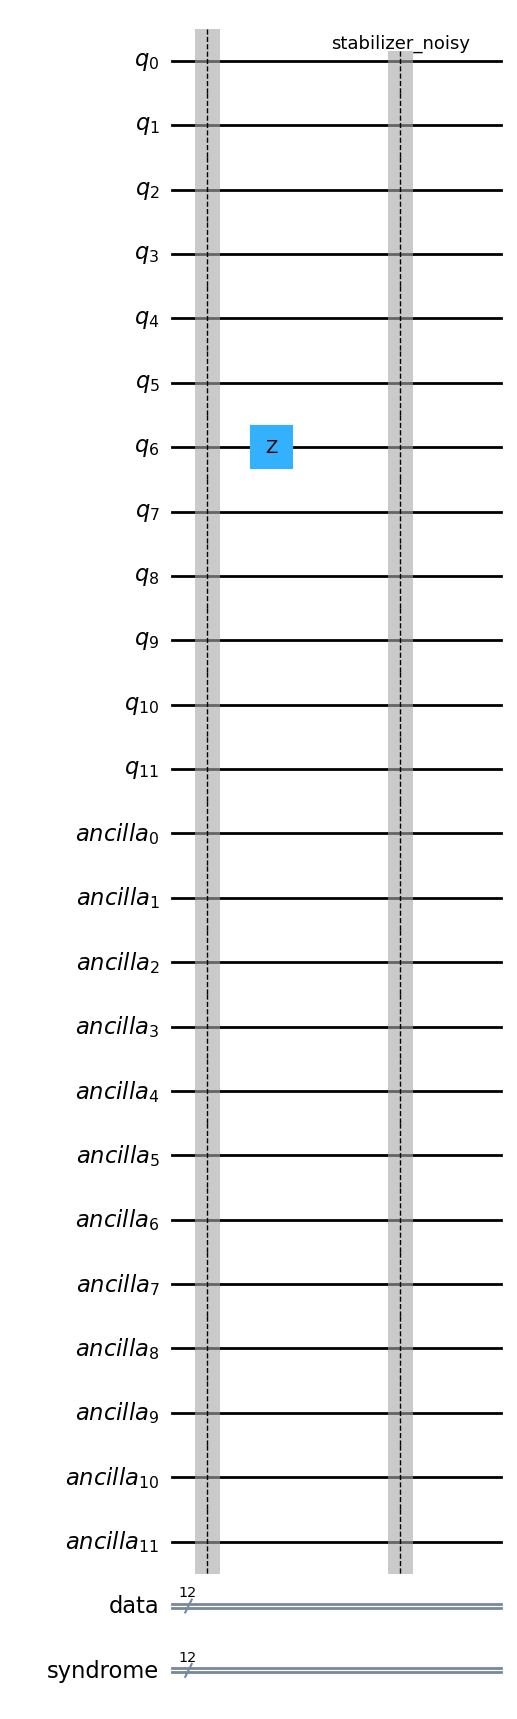

In [13]:
qc_noisy_part2 = init_circuit(post_syndrome_stabilizer)
pymatching_correction(qc_noisy_part2, measured_string)
qc_noisy_part2.save_stabilizer('stabilizer_noisy')
qc_noisy_part2.draw("mpl")  # This picture shows whether decoder found any error

In [14]:
result_noisy_correction = simulator_noisy.run(qc_noisy_part2, shots=1).result()
stabilizer_noisy = result_noisy_correction.data(0)['stabilizer_noisy']

In [15]:
print(stabilizer_ideal)
print(stabilizer_noisy)
print(stabilizer_ideal==stabilizer_noisy)

StabilizerState(['+IIIIIIIIIIIIIIZIZIIIIZIZ', '+IIIIIIIIIIIIIZIZIIIIIIZZ', '+IIIIIIIIIIIIZIIIIZIIIZZI', '+IIIIIIIIIIIIIZIIIZZIZIII', '+IIIIIIIIIIIIZIIIZIIZZIII', '+IIIIIIIIIIIIIIIIXXIIXXII', '+IIIIIIIIIIIIIIIXXIIXIIIX', '+IIIIIIIIIIIIIIIXIXXIIIXI', '+IIIIIIIIIIIIIXXIIIXIIIIX', '+IIIIIIIIIIIIXXIIIIIIXIXI', '+IIIIIIIIIIIIIIIIIIZZZZZZ', '+IIIIIIIIIIIIIIIIIZZZIZIZ', '+IIIIIIIIIIIZIIZIZIIIIZIZ', '+IIIIIIIIIIZIIZIZIIIIIIZZ', '+IIIIIIIIIZIIZIIIIZIIIZZI', '+IIIIIIIIZIIIIZIIIZZIZIII', '+IIIIIIIZIIIIZIIIZIIZZIII', '+IIIIIIZIIIIIIIZZIIZZIIII', '+IIIIIZIIIIIIIIIIXXIIXXII', '+IIIIZIIIIIIIIIIXXIIXIIIX', '+IIIZIIIIIIIIIIIXIXXIIIXI', '+IIZIIIIIIIIIIXXIIIXIIIIX', '+IZIIIIIIIIIIXXIIIIIIXIXI', '+ZIIIIIIIIIIIXIXIIIIXIXII'])
StabilizerState(['+IIIIIIIIIIIIIIZIZIIIIZIZ', '+IIIIIIIIIIIIIZIZIIIIIIZZ', '+IIIIIIIIIIIIZIIIIZIIIZZI', '+IIIIIIIIIIIIIZIIIZZIZIII', '+IIIIIIIIIIIIZIIIZIIZZIII', '+IIIIIIIIIIIIIIIIXXIIXXII', '+IIIIIIIIIIIIIIIXXIIXIIIX', '+IIIIIIIIIIIIIIIXIXXIIIXI', '+IIIIIIIIIIIIIXXIIIXIIIIX', '+IIIIII

# Step 3. Algorithmize the process to calculate logical error rates

## 3.1. Preprocessing

Ideal circuit is constructed only once

In [16]:
qc_ideal = init_circuit(full_stab_state00)
measure_stabs(qc_ideal)
qc_ideal.save_stabilizer(label='stabilizer_ideal')

simulator_ideal = AerSimulator(method="stabilizer")
result = simulator_ideal.run(qc_ideal, shots=1).result()
stabilizer_ideal = result.data(0)['stabilizer_ideal']

First part of the circuit is also constructed only once

In [17]:
qc_noisy_part1 = init_circuit(full_stab_state00)
noisy_channel(qc_noisy_part1)
measure_stabs(qc_noisy_part1)
qc_noisy_part1.save_stabilizer(label='stabilizer_noisy_part1');

## 3.2. Run simulation to calculate $p_L(p)$

In [18]:
import tqdm


def calculate_pl(prob, num_shots, stabilizer_ideal, qc_noisy_part1):


    error_1q = depolarizing_error(prob, 1)
    # error_2q = depolarizing_error(prob, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1q, ["id"])
    # noise_model.add_all_qubit_quantum_error(error_1q, ["h"])
    # noise_model.add_all_qubit_quantum_error(error_2q, ["cx"])

    outcomes = []


    for _ in tqdm.tqdm(range(num_shots)):
        simulator_noisy = AerSimulator(method='stabilizer', noise_model=noise_model)
        result_noisy_syndrome = simulator_noisy.run(qc_noisy_part1, shots=1).result()
        measured_string = result_noisy_syndrome.get_counts()
        measured_string = list(measured_string.keys())[0][0:12]
        measured_string = measured_string[::-1]
        post_syndrome_stabilizer = result_noisy_syndrome.data(0)['stabilizer_noisy_part1']


        qc_noisy_part2 = init_circuit(post_syndrome_stabilizer)
        pymatching_correction(qc_noisy_part2, measured_string)
        qc_noisy_part2.save_stabilizer('stabilizer_noisy')

        result_noisy_correction = simulator_noisy.run(qc_noisy_part2, shots=1).result()
        stabilizer_noisy = result_noisy_correction.data(0)['stabilizer_noisy']

        outcomes.append(1 if stabilizer_ideal == stabilizer_noisy else 0)
    
    outcomes = np.array(outcomes)
    success_rate = np.mean(outcomes)
    logical_error_rate = 1 - success_rate

    variance = (logical_error_rate * (1 - logical_error_rate)) / num_shots
    standard_error = np.sqrt(variance)
    
    return logical_error_rate, variance, standard_error


In [19]:
from numpy import linspace

num_shots = 10000
num_points = 10
p_values = linspace(0.0, 0.2, num_points)

p_logical_simulated = []
variances = []
standard_errors = []

for probability in p_values:
    pl, variance, std_error = calculate_pl(probability, num_shots, stabilizer_ideal, qc_noisy_part1)
    p_logical_simulated.append(pl)
    variances.append(variance)
    standard_errors.append(std_error)

100%|██████████| 10000/10000 [00:29<00:00, 342.61it/s]


## 3.3. Plot results

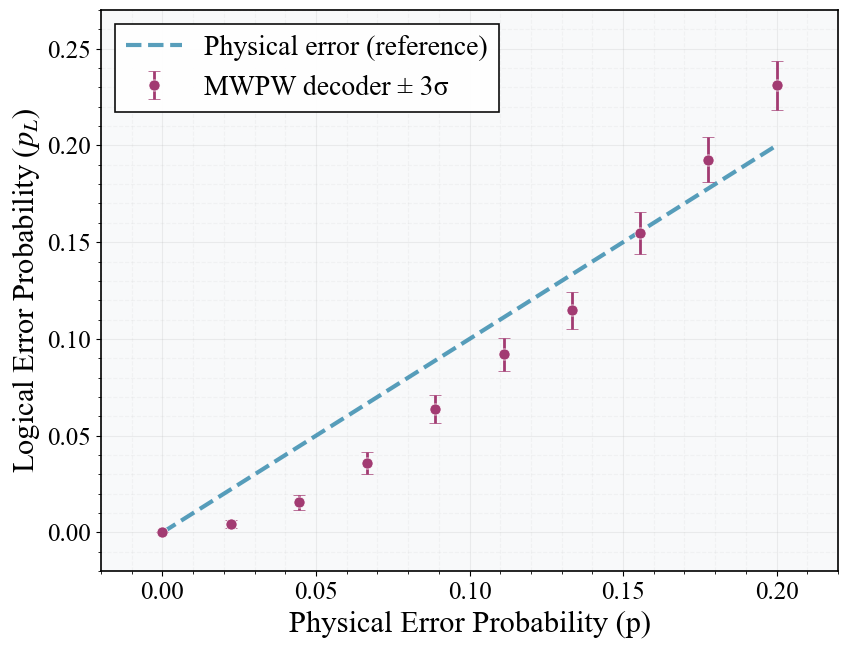

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('default')  # Reset to default then customize
plt.rcParams.update({
    'font.size': 24,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 22,
    'axes.titlesize': 24,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'legend.fontsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'errorbar.capsize': 8,
})

# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))

# Plot analytical solution
ax.plot(p_values, p_values, color='#2E86AB', linestyle='--', 
         linewidth=3, label='Physical error (reference)', alpha=0.8)

# Plot empirical data with error bars
ax.errorbar(p_values, p_logical_simulated, yerr=3*np.array(standard_errors), 
            fmt='o', color='#A23B72', 
            markerfacecolor='#A23B72', markeredgecolor='white', markeredgewidth=0.5,
            ecolor='#A23B72', elinewidth=2, capsize=4, capthick=2,
            label='MWPW decoder ± 3σ')

# Customize the plot
ax.set_xlabel('Physical Error Probability (p)', fontsize=22)
ax.set_ylabel('Logical Error Probability ($p_L$)', fontsize=22)
# ax.set_title('9-qubit Shor Code Analysis', fontsize=24, pad=20)

# Set axis limits and ticks
ax.set_xlim(-0.02, max(p_values) + 0.02)
ax.set_ylim(-0.02, 0.27)
ax.set_xticks(np.arange(0, max(p_values) + 0.05, 0.05))
ax.set_yticks(np.arange(0.0, 0.27, 0.05))

# Add grid
ax.grid(True, linestyle='-', alpha=0.2, which='both')
ax.grid(True, linestyle='--', alpha=0.1, which='minor')
ax.minorticks_on()

# Customize legend
legend = ax.legend(loc='upper left', framealpha=0.95, 
                   edgecolor='black', fancybox=False,
                   facecolor='white')
legend.get_frame().set_linewidth(1.2)


ax.set_facecolor('#f8f9fa')
plt.tight_layout()

# Save as PNG
plt.savefig('data/ldpc_error_rate.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

plt.show()